# Approach 1 (Not a submission)
In order to deal with a 3d matrix, in the first approach I decided to was to provide some combined statistics of the properties and tried variuos test models. However logically it broke the individuality of the particles as well as the interrelation with them

Loading quark-gluon jet dataset...
Extracting features from particle data...
Splitting data into training and testing sets...

Training KNN classifier...
Training Random Forest classifier...
Training Neural Network...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training SVM classifier (on subset of data)...


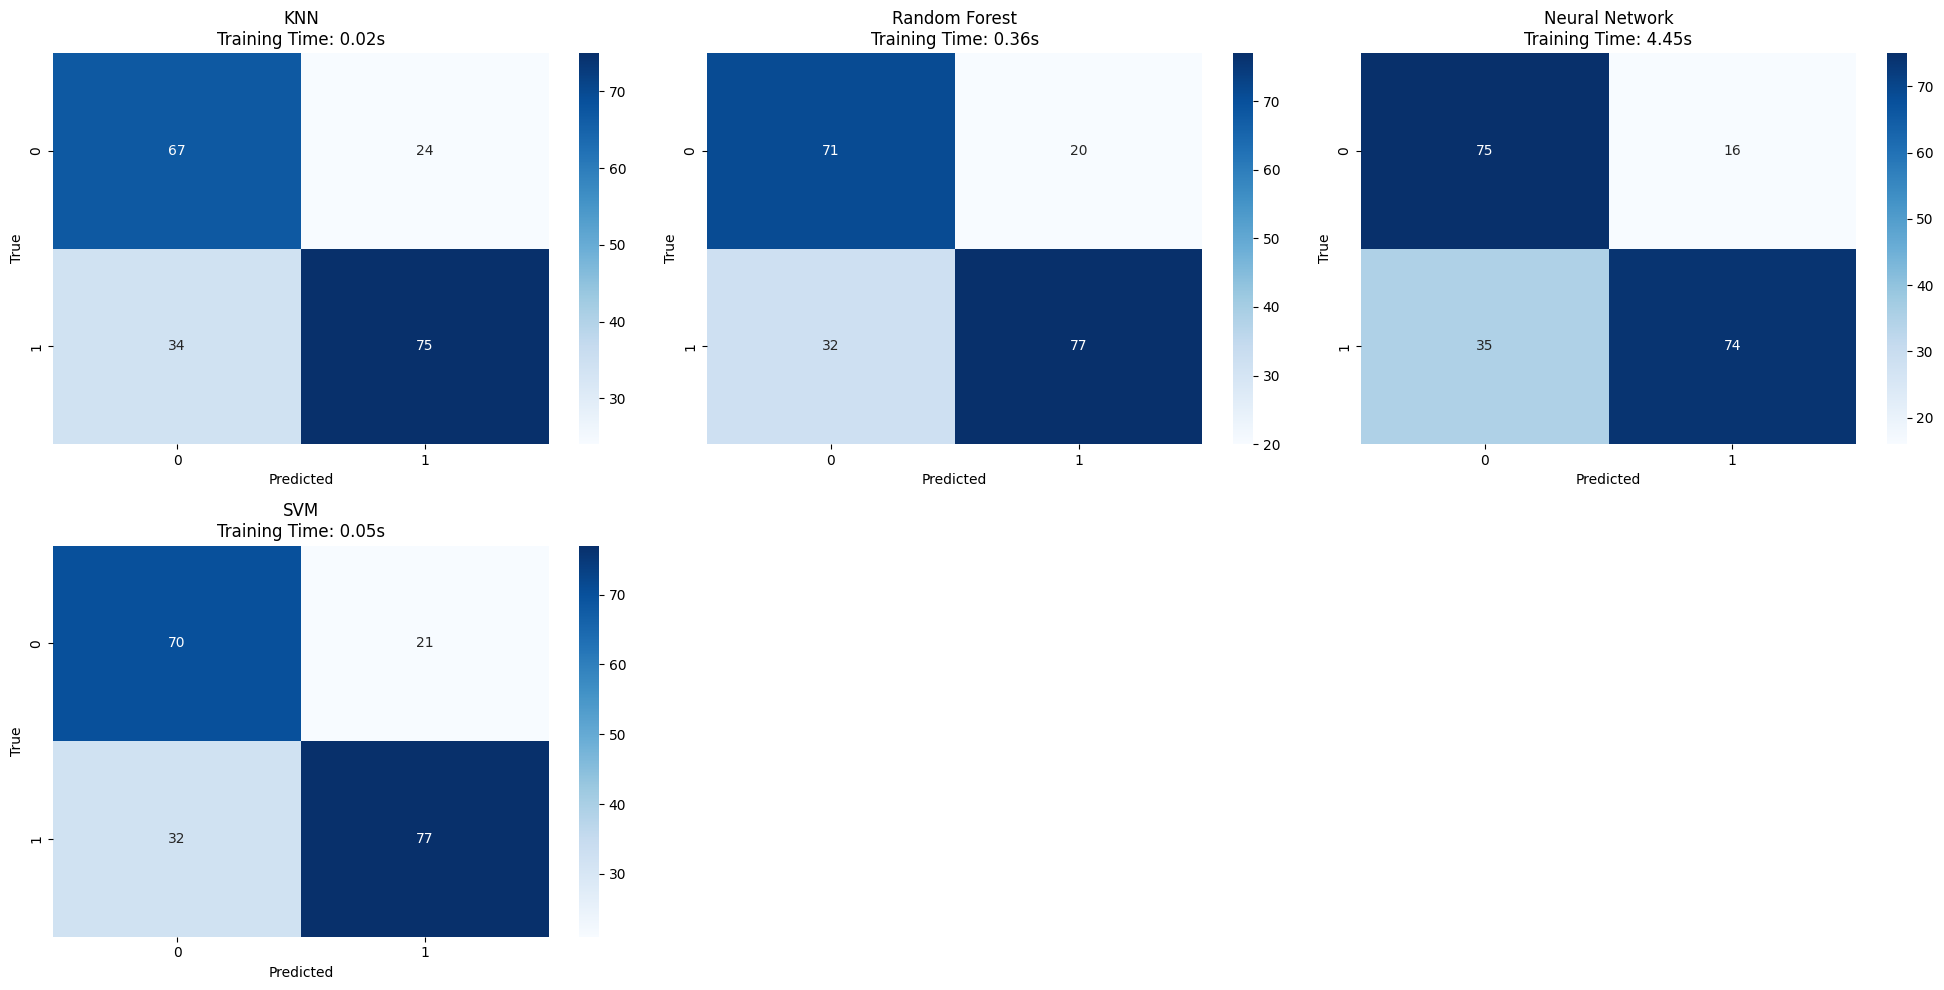


Classification Reports:

KNN Results:
              precision    recall  f1-score   support

         0.0       0.66      0.74      0.70        91
         1.0       0.76      0.69      0.72       109

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.71      0.71      0.71       200

Training Time: 0.02 seconds

Random Forest Results:
              precision    recall  f1-score   support

         0.0       0.69      0.78      0.73        91
         1.0       0.79      0.71      0.75       109

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200

Training Time: 0.36 seconds

Neural Network Results:
              precision    recall  f1-score   support

         0.0       0.68      0.82      0.75        91
         1.0       0.82      0.68      0.74       109

    accuracy                          

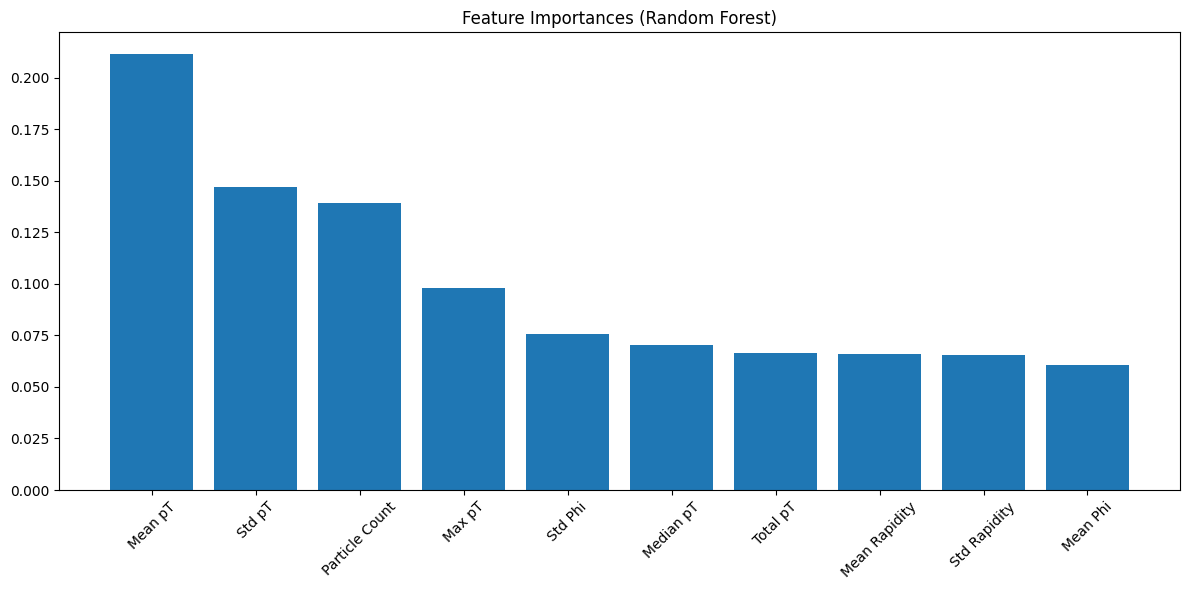

In [68]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
!pip install energyflow
import energyflow as ef
from energyflow.datasets import qg_jets
import xgboost as xgb
import time

# Load the dataset using energyflow
print("Loading quark-gluon jet dataset...")
X, y = ef.qg_jets.load(num_data=1000, pad=True)

# Extract features from raw particle data
print("Extracting features from particle data...")

# We'll create meaningful physics-based features
processed_features = []
for jet in X:
    # Remove padding (zero rows)
    valid_particles = jet[~np.all(jet == 0, axis=1)]

    # Calculate jet-level features
    jet_features = [
        # Momentum features
        np.mean(valid_particles[:, 0]),     # Mean transverse momentum
        np.std(valid_particles[:, 0]),      # Std of transverse momentum
        np.max(valid_particles[:, 0]),      # Maximum transverse momentum

        # Rapidity features
        np.mean(valid_particles[:, 1]),     # Mean rapidity
        np.std(valid_particles[:, 1]),      # Rapidity spread

        # Angular features
        np.mean(valid_particles[:, 2]),     # Mean azimuthal angle
        np.std(valid_particles[:, 2]),      # Angular spread

        # Particle multiplicity
        len(valid_particles),               # Number of particles

        # Additional physics-inspired features
        np.sum(valid_particles[:, 0]),      # Total momentum
        np.median(valid_particles[:, 0]),   # Median momentum
    ]
    processed_features.append(jet_features)

# Convert to numpy array
X_processed = np.array(processed_features)

# Split the data
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store results
results = {}

# 1. K-Nearest Neighbors
print("\nTraining KNN classifier...")
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)
knn_time = time.time() - start_time
results['KNN'] = {
    'predictions': knn_pred,
    'time': knn_time
}

# 2. Random Forest
print("Training Random Forest classifier...")
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_time = time.time() - start_time
results['Random Forest'] = {
    'predictions': rf_pred,
    'time': rf_time
}


# 3. Neural Network
print("Training Neural Network...")
start_time = time.time()

# Create a simple neural network
nn = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)
nn_pred = (nn.predict(X_test_scaled) > 0.5).astype(int)
nn_time = time.time() - start_time
results['Neural Network'] = {
    'predictions': nn_pred,
    'time': nn_time
}

# 4. Support Vector Machine (with subset of data due to computational complexity)
print("Training SVM classifier (on subset of data)...")
# Take a subset of data for SVM due to computational complexity
subset_size = 5000
X_train_sub = X_train_scaled[:subset_size]
y_train_sub = y_train[:subset_size]
X_test_sub = X_test_scaled[:subset_size]
y_test_sub = y_test[:subset_size]

start_time = time.time()
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_sub, y_train_sub)
svm_pred = svm.predict(X_test_sub)
svm_time = time.time() - start_time
results['SVM'] = {
    'predictions': svm_pred,
    'time': svm_time
}

# Visualization and Results
plt.figure(figsize=(20, 10))

# Plot confusion matrices for all classifiers
for i, (name, result) in enumerate(results.items()):
    plt.subplot(2, 3, i+1)
    if name == 'SVM':
        cm = confusion_matrix(y_test_sub, result['predictions'])
    else:
        cm = confusion_matrix(y_test, result['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name}\nTraining Time: {result["time"]:.2f}s')
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# Print classification reports
print("\nClassification Reports:")
for name, result in results.items():
    print(f"\n{name} Results:")
    if name == 'SVM':
        print(classification_report(y_test_sub, result['predictions']))
    else:
        print(classification_report(y_test, result['predictions']))
    print(f"Training Time: {result['time']:.2f} seconds")

# Compare feature importance for tree-based models
feature_names = [
    'Mean pT', 'Std pT', 'Max pT', 'Mean Rapidity', 'Std Rapidity',
    'Mean Phi', 'Std Phi', 'Particle Count', 'Total pT', 'Median pT'
]

plt.figure(figsize=(12, 6))
# Plot feature importance for Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances (Random Forest)')
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# Submission
AI info - " The logic of the code and the flow of the code has no involvement of AI. AI models have been used only to generate the code after providig them the logic and the required fields and parameters that need to be placed at spots"

In [70]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from energyflow.datasets import qg_jets
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import pandas as pd

# Load the dataset
print("Loading particle physics dataset...")
X, y = qg_jets.load(num_data=40000, pad=True)

# Function to identify and remove zero-padded particles
def remove_zero_particles(X):
    # In particle physics, we often use pT (transverse momentum) to identify real particles
    # pT is stored as the first feature for each particle
    pt_values = X[:, :, 0]
    # Create mask for particles with significant pT
    # The threshold 1e-6 helps eliminate computational artifacts
    non_zero_mask = pt_values > 1e-6
    return non_zero_mask

# Split data at jet level first to maintain physics integrity
X_jets_train, X_jets_test, y_jets_train, y_jets_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Get masks for non-zero particles
train_mask = remove_zero_particles(X_jets_train)
test_mask = remove_zero_particles(X_jets_test)

def process_jets(X_jets, y_jets, mask):
    """
    Process jets to create particle-level training data.
    This function removes zero-padded particles and maintains the connection
    between particles and their parent jets.
    """
    n_jets = X_jets.shape[0]
    n_features = X_jets.shape[2]

    # Initialize lists to store processed data
    X_particles = []
    y_particles = []
    jet_indices = []

    # Process each jet individually
    for jet_idx in range(n_jets):
        # Select only real particles (non-zero pT) from this jet
        valid_particles = X_jets[jet_idx][mask[jet_idx]]
        if len(valid_particles) > 0:
            X_particles.append(valid_particles)
            # Each particle inherits its jet's label
            y_particles.extend([y_jets[jet_idx]] * len(valid_particles))
            # Keep track of which jet each particle came from
            jet_indices.extend([jet_idx] * len(valid_particles))

    return (np.vstack(X_particles),
            np.array(y_particles),
            np.array(jet_indices))

# Process training and test data
print("Processing particle data...")
X_particles_train, y_particles_train, train_jet_indices = process_jets(
    X_jets_train, y_jets_train, train_mask)
X_particles_test, y_particles_test, test_jet_indices = process_jets(
    X_jets_test, y_jets_test, test_mask)

# Scale particle features for better Random Forest performance
particle_scaler = StandardScaler()
X_particles_train_scaled = particle_scaler.fit_transform(X_particles_train)
X_particles_test_scaled = particle_scaler.transform(X_particles_test)

print("Training first-stage Random Forest (particle level)...")
# First stage: Particle-level classification
particle_classifier = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest
    max_depth=10,              # Maximum depth of each tree
    min_samples_split=20,      # Minimum samples required to split a node
    min_samples_leaf=10,       # Minimum samples required at a leaf node
    bootstrap=True,            # Use bootstrapped samples
    class_weight='balanced',   # Handle class imbalance
    n_jobs=-1,                # Use all available cores
    random_state=42
)
particle_classifier.fit(X_particles_train_scaled, y_particles_train)

# Get particle-level predictions
particle_proba_train = particle_classifier.predict_proba(X_particles_train_scaled)[:, 1]
particle_proba_test = particle_classifier.predict_proba(X_particles_test_scaled)[:, 1]

def create_jet_features(probas, jet_indices, n_jets):
    """
    Create jet-level features from particle probabilities.
    These features capture the statistical properties of particle distributions within each jet.
    """
    jet_features = np.zeros((n_jets, 8))
    jet_counts = np.zeros(n_jets)

    # First pass: collect basic statistics
    for idx, proba in zip(jet_indices, probas):
        jet_counts[idx] += 1
        jet_features[idx, 0] += proba  # For mean
        jet_features[idx, 2] = max(jet_features[idx, 2], proba)  # Max
        jet_features[idx, 3] = min(proba, jet_features[idx, 3]) if jet_features[idx, 3] > 0 else proba  # Min

    # Second pass: compute advanced statistics
    for idx in range(n_jets):
        if jet_counts[idx] > 0:
            # Basic statistics
            jet_features[idx, 0] /= jet_counts[idx]  # Mean
            jet_probas = probas[jet_indices == idx]
            jet_features[idx, 1] = np.std(jet_probas)  # Standard deviation
            jet_features[idx, 2] = np.max(jet_probas)  # Median
            jet_features[idx, 3] = np.min(jet_probas)  # Median
            jet_features[idx, 4] = np.median(jet_probas)  # Median

            # Advanced features
            jet_features[idx, 5] = np.sum(jet_probas > 0.5) / len(jet_probas)  # Quark-like fraction
            jet_features[idx, 6] = np.sum(jet_probas > 0.8) / len(jet_probas)  # 75th percentile
            jet_features[idx, 7] = np.sum(jet_probas < 0.2) / len(jet_probas)  # 25th percentile
    return jet_features

# Create jet-level features
print("Creating jet-level features...")
X_jets_train_features = create_jet_features(particle_proba_train, train_jet_indices, len(y_jets_train))
X_jets_test_features = create_jet_features(particle_proba_test, test_jet_indices, len(y_jets_test))

# Scale jet features
jet_scaler = StandardScaler()
X_jets_train_scaled = jet_scaler.fit_transform(X_jets_train_features)
X_jets_test_scaled = jet_scaler.transform(X_jets_test_features)

print("Training second-stage Random Forest (jet level)...")
# Second stage: Jet-level classification
jet_classifier = RandomForestClassifier(
    n_estimators=200,          # More trees for final classification
    max_depth=15,              # Allow deeper trees for complex jet patterns
    min_samples_split=10,      # More aggressive splitting
    min_samples_leaf=5,        # Smaller leaf size for fine-grained predictions
    bootstrap=True,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
jet_classifier.fit(X_jets_train_scaled, y_jets_train)

# Make final predictions
jet_predictions = jet_classifier.predict(X_jets_test_scaled)
jet_probabilities = jet_classifier.predict_proba(X_jets_test_scaled)[:, 1]

# Calculate comprehensive performance metrics
particle_accuracy = accuracy_score(y_particles_test,
                                 particle_classifier.predict(X_particles_test_scaled))
jet_accuracy = accuracy_score(y_jets_test, jet_predictions)
jet_auc = roc_auc_score(y_jets_test, jet_probabilities)

print("\nPerformance Metrics:")
print("=" * 50)
print(f"Particle-level classification accuracy: {particle_accuracy:.4f}")
print(f"Final jet classification accuracy: {jet_accuracy:.4f}")
print(f"Jet classification ROC AUC: {jet_auc:.4f}")

# Analyze feature importance for particle-level classification
particle_feature_names = ['pT', 'rapidity', 'phi', 'PDG_ID']
particle_importance = pd.DataFrame({
    'Feature': particle_feature_names,
    'Importance': particle_classifier.feature_importances_
})
particle_importance = particle_importance.sort_values('Importance', ascending=False)

print("\nParticle-Level Feature Importance:")
print("=" * 50)
for idx, row in particle_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Analyze feature importance for jet-level classification
jet_feature_names = [
    'Mean Particle Prob',
    'Std Particle Prob',
    'Max Particle Prob',
    'Min Particle Prob',
    'Median Particle Prob',
    'Quark-like Fraction',
    '75th Percentile',
    '25th Percentile'
]
print(len(jet_feature_names) , len(jet_classifier.feature_importances_))
jet_importance = pd.DataFrame({
    'Feature': jet_feature_names,
    'Importance': jet_classifier.feature_importances_
})
jet_importance = jet_importance.sort_values('Importance', ascending=False)

print("\nJet-Level Feature Importance:")
print("=" * 50)
for idx, row in jet_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Print confusion matrix with interpretation
conf_matrix = confusion_matrix(y_jets_test, jet_predictions)
print("\nConfusion Matrix:")
print("=" * 50)
print("          Predicted Gluon  Predicted Quark")
print(f"True Gluon      {conf_matrix[0,0]}           {conf_matrix[0,1]}")
print(f"True Quark      {conf_matrix[1,0]}           {conf_matrix[1,1]}")

# Calculate additional performance metrics per class
gluon_precision = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
quark_precision = conf_matrix[1,1] / (conf_matrix[0,1] + conf_matrix[1,1])
gluon_recall = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
quark_recall = conf_matrix[1,1] / (conf_matrix[1,0] + conf_matrix[1,1])

print("\nPer-Class Performance:")
print("=" * 50)
print(f"Gluon Precision: {gluon_precision:.4f}")
print(f"Quark Precision: {quark_precision:.4f}")
print(f"Gluon Recall: {gluon_recall:.4f}")
print(f"Quark Recall: {quark_recall:.4f}")

Loading particle physics dataset...
Processing particle data...
Training first-stage Random Forest (particle level)...
Creating jet-level features...
Training second-stage Random Forest (jet level)...

Performance Metrics:
Particle-level classification accuracy: 0.5837
Final jet classification accuracy: 0.7731
Jet classification ROC AUC: 0.8448

Particle-Level Feature Importance:
pT: 0.7031
rapidity: 0.1036
phi: 0.0977
PDG_ID: 0.0956
8 8

Jet-Level Feature Importance:
Std Particle Prob: 0.3387
Max Particle Prob: 0.1823
Mean Particle Prob: 0.1515
75th Percentile: 0.1138
Quark-like Fraction: 0.0906
Median Particle Prob: 0.0651
Min Particle Prob: 0.0578
25th Percentile: 0.0002

Confusion Matrix:
          Predicted Gluon  Predicted Quark
True Gluon      3189           721
True Quark      1094           2996

Per-Class Performance:
Gluon Precision: 0.7446
Quark Precision: 0.8060
Gluon Recall: 0.8156
Quark Recall: 0.7325


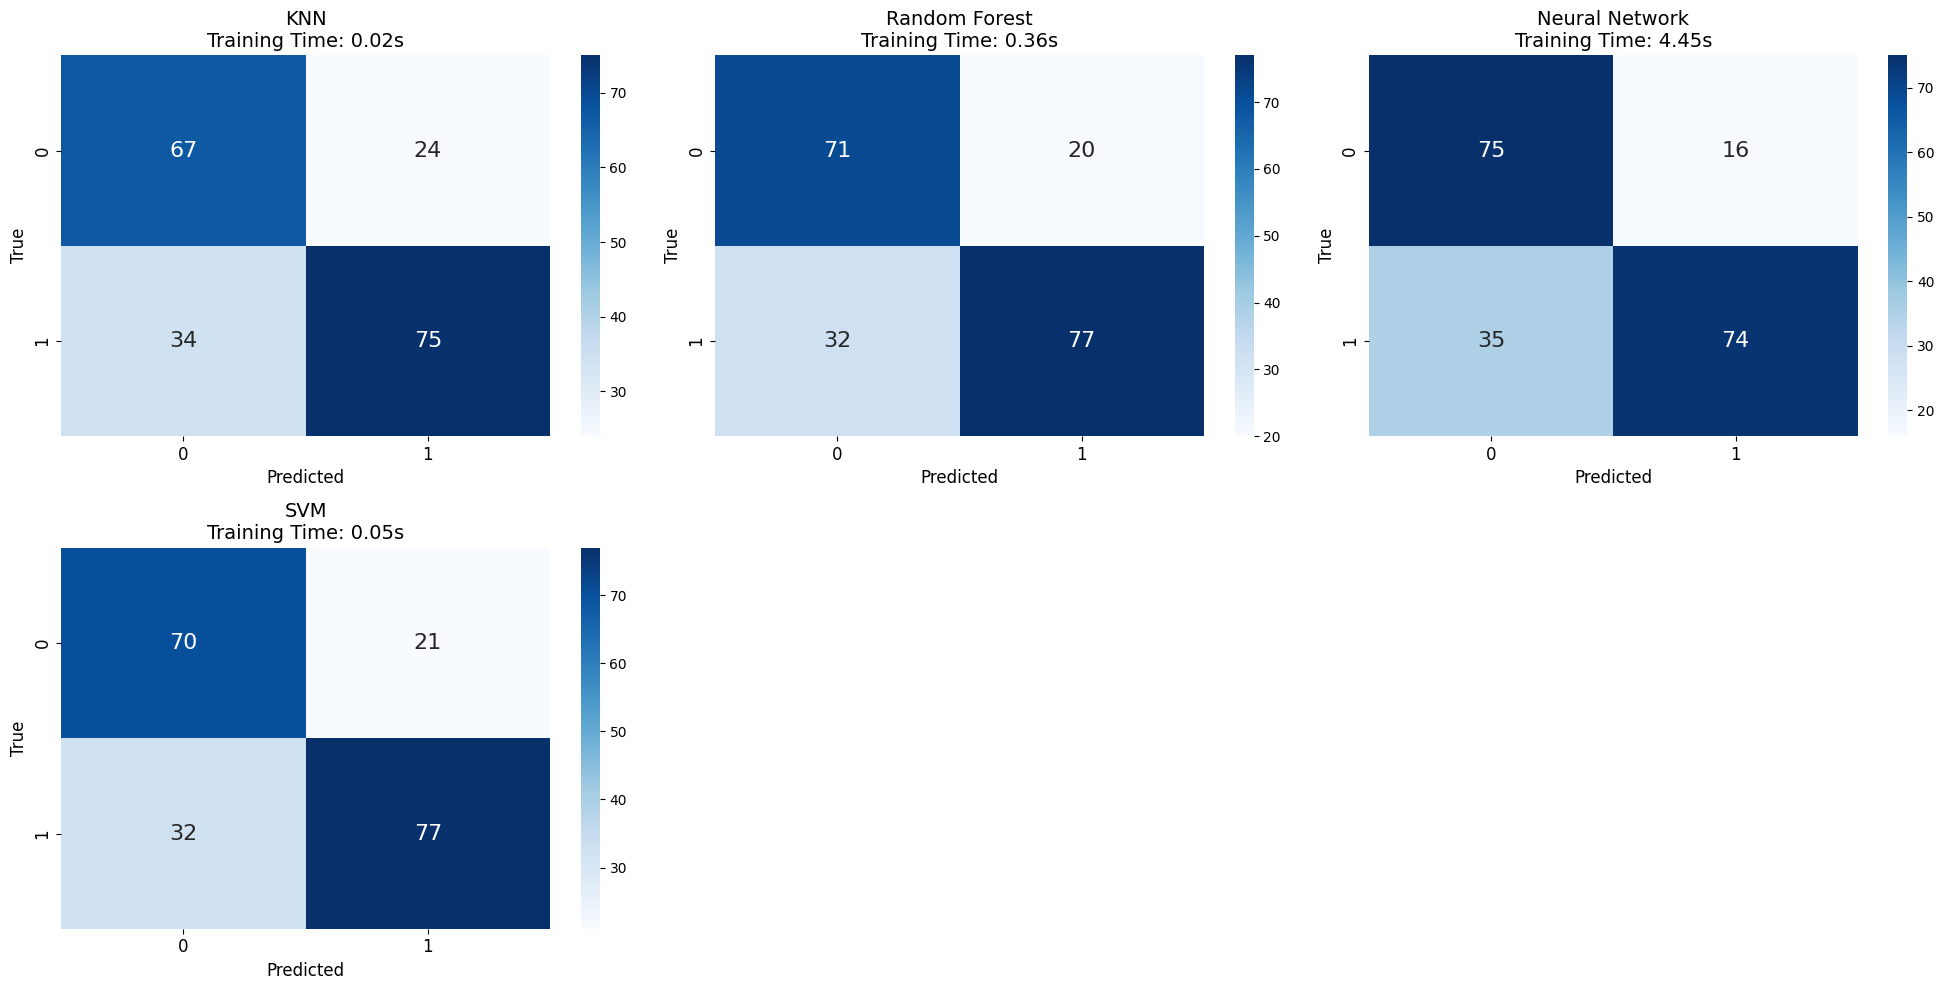

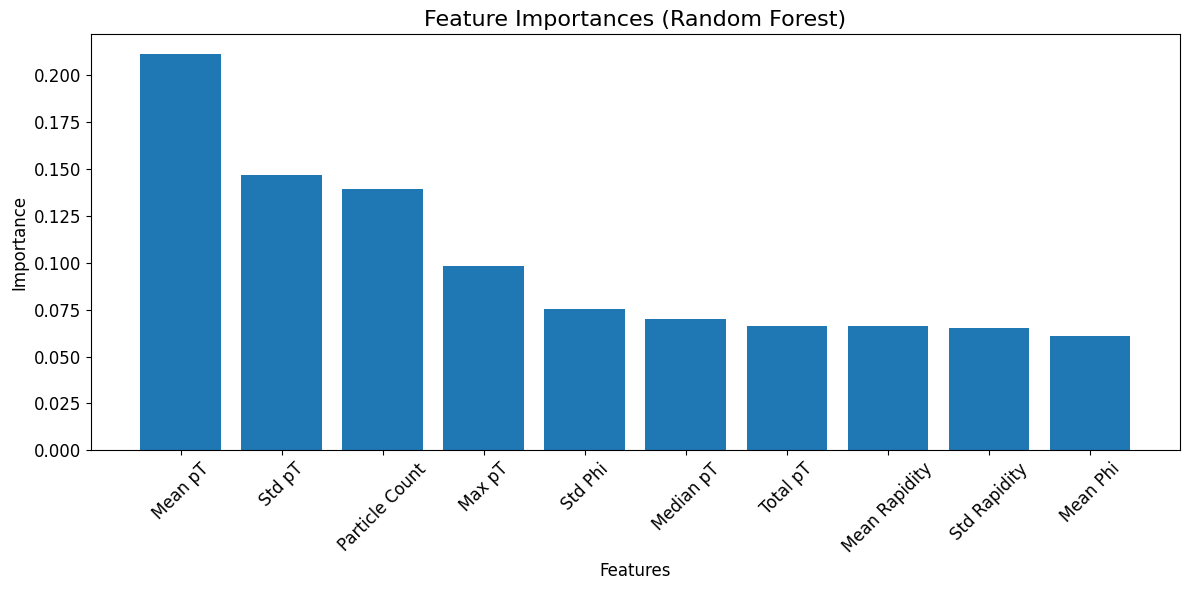

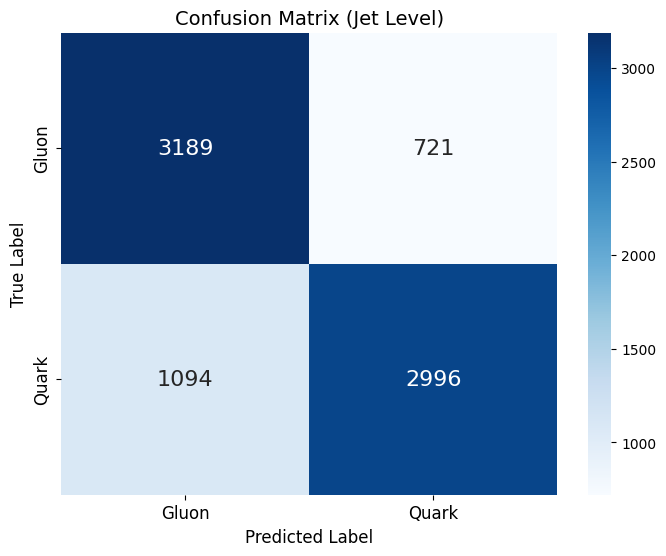

In [73]:

# This part for visualition is completely generated using AI
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualization and Results (Modified)
plt.figure(figsize=(20, 10))

# Plot confusion matrices for all classifiers
for i, (name, result) in enumerate(results.items()):
    plt.subplot(2, 3, i+1)
    cm = confusion_matrix(y_test, result['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}) # Increased font size
    plt.title(f'{name}\nTraining Time: {result["time"]:.2f}s', fontsize=14) # Increased title font size
    plt.xlabel('Predicted', fontsize=12) # Increased label font size
    plt.ylabel('True', fontsize=12) # Increased label font size
    plt.xticks(fontsize=12) # Increase x-axis ticks font size
    plt.yticks(fontsize=12) # Increase y-axis ticks font size

plt.tight_layout()
plt.show()



# Feature Importance Visualization (Enhanced)
plt.figure(figsize=(12, 6))
# Plot feature importance for Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances (Random Forest)', fontsize=16) # Increased title font size
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=45, fontsize=12)  # Increased x-ticks font size
plt.yticks(fontsize=12) # Increased y-ticks font size
plt.xlabel("Features", fontsize=12) # x-axis label
plt.ylabel("Importance", fontsize=12) # y-axis label
plt.tight_layout()
plt.show()



# Confusion matrix visualization for the final jet classifier
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16},
            xticklabels=['Gluon', 'Quark'], yticklabels=['Gluon', 'Quark'])
plt.title('Confusion Matrix (Jet Level)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=12) # Increase x-axis ticks font size
plt.yticks(fontsize=12) # Increase y-axis ticks font size
plt.show()
